# WhatsApp Chat Analysis

In [ ]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip3 install wordcloud
from wordcloud import WordCloud, STOPWORDS
import re
import collections
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Conentional way to import data

In [27]:
path=(r"C:\Users\Vani_\Desktop\Downloaded project files\whatsapp.txt")
df=pd.read_csv(path,sep='delimiter', header=None) 

In [28]:
df.head(10)

,0
0,"12/08/2019, 3:23 pm - Messages and calls are e..."
1,"12/08/2019, 3:23 pm - Vinay IPL created group ..."
2,"12/08/2019, 3:23 pm - Vinay IPL added you"
3,"12/08/2019, 3:26 pm - Vinay IPL added Sejal, +..."
4,"12/08/2019, 4:13 pm - TDS: Any introduction he..."
5,"12/08/2019, 4:16 pm - Ipsita: Okay ...so y was..."
6,"12/08/2019, 4:18 pm - TDS: I don't know either..."
7,"12/08/2019, 4:20 pm - Vinay IPL changed the gr..."
8,"12/08/2019, 4:22 pm - Vinay IPL: Hope Bright c..."
9,"12/08/2019, 4:23 pm - Vinay IPL: <Media omitted>"


In [29]:
df.sample(10)

,0
6968,Topic: Rehearsal for UX Skillathon with Prof A...
10262,"mock test is scheduled from today, timing is 1..."
4965,"03/03/2020, 10:15 am - Supriya: Congratulations ☺"
6443,"02/05/2020, 12:01 pm - Shubham: Okay thanks sir👍🏻"
3706,"16/01/2020, 7:37 pm - TDS: 👍"
11761,"09/03/2021, 6:48 pm - Basu: Congratulations"
8838,"22/10/2020, 10:42 am - Shubham: Shubham Bonde"
10078,"Best Regards,"
10423,"01/01/2021, 12:04 am - Piyush: <Media omitted>"
5999,"07/04/2020, 9:52 pm - Guru: Please check now."


Importing data by creating a function. 
As in the above data, you need to identify if a line is a new message or part of an old message. You could use regular expressions
While reading each line, split it based on a comma and take the first item returned from the split() function. If the line is a new message, the first item would be a valid date, and it will be appended as a new message to the list of messages. If it’s not, the message is part of the previous message, and hence, will be appended to the end of the previous message as one continuous message.

In [30]:
def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''
    
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
       # '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        #'24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }
    
    with open(file, 'r', encoding='utf-8') as raw_data:
        # print(raw_data.read())
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else:
            usernames.append("group_notification")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    return df

Import data using the above function

In [31]:
df = rawToDf(path, '12hr')
df

,date_time,user,message
0,2019-08-12 15:23:00,group_notification,Messages and calls are end-to-end encrypted. N...
1,2019-08-12 15:23:00,group_notification,"Vinay IPL created group ""MIT - MBA FT Academics"""
2,2019-08-12 15:23:00,group_notification,Vinay IPL added you
3,2019-08-12 15:26:00,group_notification,"Vinay IPL added Sejal, +91 97380 42112 and +91..."
4,2019-08-12 16:13:00,TDS,Any introduction here??
...,...,...,...
7379,2021-05-25 17:52:00,Shahid,Congratulations @919503089525 👏👏
7380,2021-05-25 18:31:00,Arti,Congratulations kalyani
7381,2021-05-25 20:49:00,Kalyani,Thank you everyone ☺️🥳
7382,2021-05-26 13:04:00,IPL2,https://www.linkedin.com/jobs/view/2555161007 ...


Exploring the column "user" of the dataframe "df"


In [36]:
df.user.unique()


array(['group_notification', 'TDS', 'Ipsita', 'Vinay IPL',
       '+91 98816 67812', 'Piyush', 'Dhanashree', 'Supriya', 'Naveen',
       'Zaki', 'Shahid', 'Sushanth', 'Basu', 'Shubham', '+91 96547 32364',
       '+91 99715 00974', 'Pranit', 'Meera', 'Ninad Ipl', 'Neelima',
       'Juhi', '+91 90288 11938', 'Yash', 'Arti', 'Kalyani',
       'Supriya Patil', '+91 73372 38278', 'Komal', 'Nikhil', 'Pallavi',
       '+91 82082 32720', 'Rahul IPL', 'Souredeep', 'Vrushabh',
       '+91 83083 01031', '+91 98867 12878', '+91 74116 71299', 'Umesh',
       'Mohan', 'Guru', 'Omkar MBA', "Poonam Ma'am", '+91 99456 10428',
       "Sonali Ma'am", 'Raju Gurav MIT', '+91 98230 10005',
       '+91 80735 56748', '+91 99594 20006', '+91 80955 06555',
       '+91 88844 38555', '+91 70584 12100', 'Koustav', '+91 95911 84093',
       'IPL2', '+91 96118 23086', 'IPL Sai Sunder', 'Sejal',
       '+91 88844 46840', '+91 82900 32080', '+91 84319 67270',
       '+91 79880 12812'], dtype=object)

In [37]:
df.user.value_counts() #ascending=FALSE

IPL Sai Sunder     1084
Guru                903
Koustav             380
Juhi                307
Meera               223
                   ... 
+91 99456 10428       3
+91 79880 12812       2
Rahul IPL             1
+91 98230 10005       1
+91 95911 84093       1
Name: user, Length: 61, dtype: int64

In [38]:
df['user'].nunique()

61

Prints information about the dataframe

In [39]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7384 entries, 0 to 7383
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  7384 non-null   datetime64[ns]
 1   user       7384 non-null   object        
 2   message    7384 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 173.2+ KB


Seperating date_time column into day, month, year and date

In [40]:
df['day'] = df['date_time'].dt.strftime('%A')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())
df

,date_time,user,message,day,month,year,date
0,2019-08-12 15:23:00,group_notification,Messages and calls are end-to-end encrypted. N...,Monday,Aug,2019,2019-08-12
1,2019-08-12 15:23:00,group_notification,"Vinay IPL created group ""MIT - MBA FT Academics""",Monday,Aug,2019,2019-08-12
2,2019-08-12 15:23:00,group_notification,Vinay IPL added you,Monday,Aug,2019,2019-08-12
3,2019-08-12 15:26:00,group_notification,"Vinay IPL added Sejal, +91 97380 42112 and +91...",Monday,Aug,2019,2019-08-12
4,2019-08-12 16:13:00,TDS,Any introduction here??,Monday,Aug,2019,2019-08-12
...,...,...,...,...,...,...,...
7379,2021-05-25 17:52:00,Shahid,Congratulations @919503089525 👏👏,Tuesday,May,2021,2021-05-25
7380,2021-05-25 18:31:00,Arti,Congratulations kalyani,Tuesday,May,2021,2021-05-25
7381,2021-05-25 20:49:00,Kalyani,Thank you everyone ☺️🥳,Tuesday,May,2021,2021-05-25
7382,2021-05-26 13:04:00,IPL2,https://www.linkedin.com/jobs/view/2555161007 ...,Wednesday,May,2021,2021-05-26


Getting message count on a date

In [42]:
new_df = df.copy()      # let's use a copy of our dataset for this analysis.
new_df['message_count'] = new_df.shape[0]*[1]                #shape[0]*[1] just adds 1 to rows  
new_df

,date_time,user,message,day,month,year,date,message_count
0,2019-08-12 15:23:00,group_notification,Messages and calls are end-to-end encrypted. N...,Monday,Aug,2019,2019-08-12,1
1,2019-08-12 15:23:00,group_notification,"Vinay IPL created group ""MIT - MBA FT Academics""",Monday,Aug,2019,2019-08-12,1
2,2019-08-12 15:23:00,group_notification,Vinay IPL added you,Monday,Aug,2019,2019-08-12,1
3,2019-08-12 15:26:00,group_notification,"Vinay IPL added Sejal, +91 97380 42112 and +91...",Monday,Aug,2019,2019-08-12,1
4,2019-08-12 16:13:00,TDS,Any introduction here??,Monday,Aug,2019,2019-08-12,1
...,...,...,...,...,...,...,...,...
7379,2021-05-25 17:52:00,Shahid,Congratulations @919503089525 👏👏,Tuesday,May,2021,2021-05-25,1
7380,2021-05-25 18:31:00,Arti,Congratulations kalyani,Tuesday,May,2021,2021-05-25,1
7381,2021-05-25 20:49:00,Kalyani,Thank you everyone ☺️🥳,Tuesday,May,2021,2021-05-25,1
7382,2021-05-26 13:04:00,IPL2,https://www.linkedin.com/jobs/view/2555161007 ...,Wednesday,May,2021,2021-05-26,1


In [43]:
new_df = new_df.groupby("date").sum().reset_index() 
new_df.drop(columns='year', inplace=True)
new_df

,date,message_count
0,2019-08-12,19
1,2019-08-13,3
2,2019-08-14,19
3,2019-08-15,3
4,2019-08-18,19
...,...,...
534,2021-05-22,5
535,2021-05-23,6
536,2021-05-24,29
537,2021-05-25,15


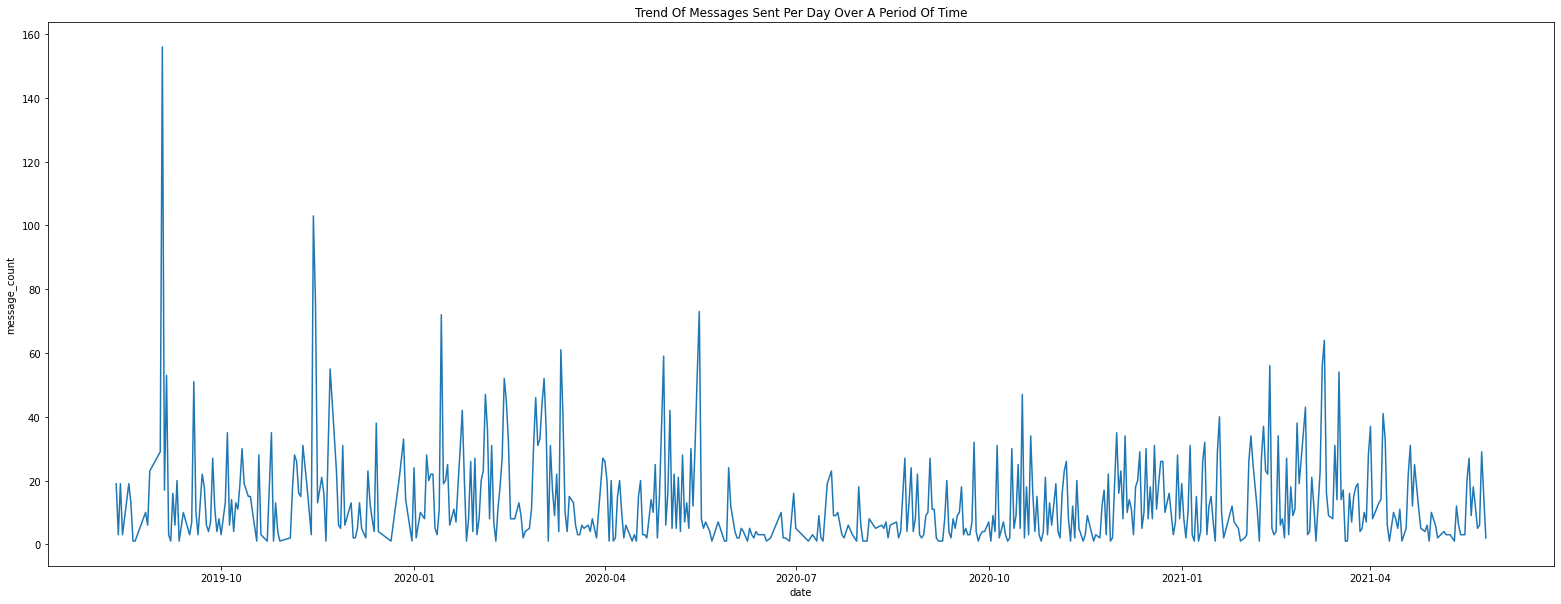

In [44]:
new_df.tail(10)
plt.figure(figsize = (27, 10)) 
plt.title('Trend Of Messages Sent Per Day Over A Period Of Time');
sns.lineplot(new_df.date, new_df.message_count); 

Message count per user

In [46]:
new_df1=df.copy()
new_df1.tail(10)
new_df1 = new_df1[new_df1.user != "group_notification"]
new_df1 = new_df1.groupby('user').size().reset_index(name='CountPerUser')
new_df1

,user,CountPerUser
0,+91 70584 12100,59
1,+91 73372 38278,32
2,+91 74116 71299,56
3,+91 79880 12812,2
4,+91 80735 56748,13
5,+91 80955 06555,13
6,+91 82082 32720,96
7,+91 82900 32080,28
8,+91 83083 01031,98
9,+91 84319 67270,4


Text(0, 0.5, 'Count Per User')

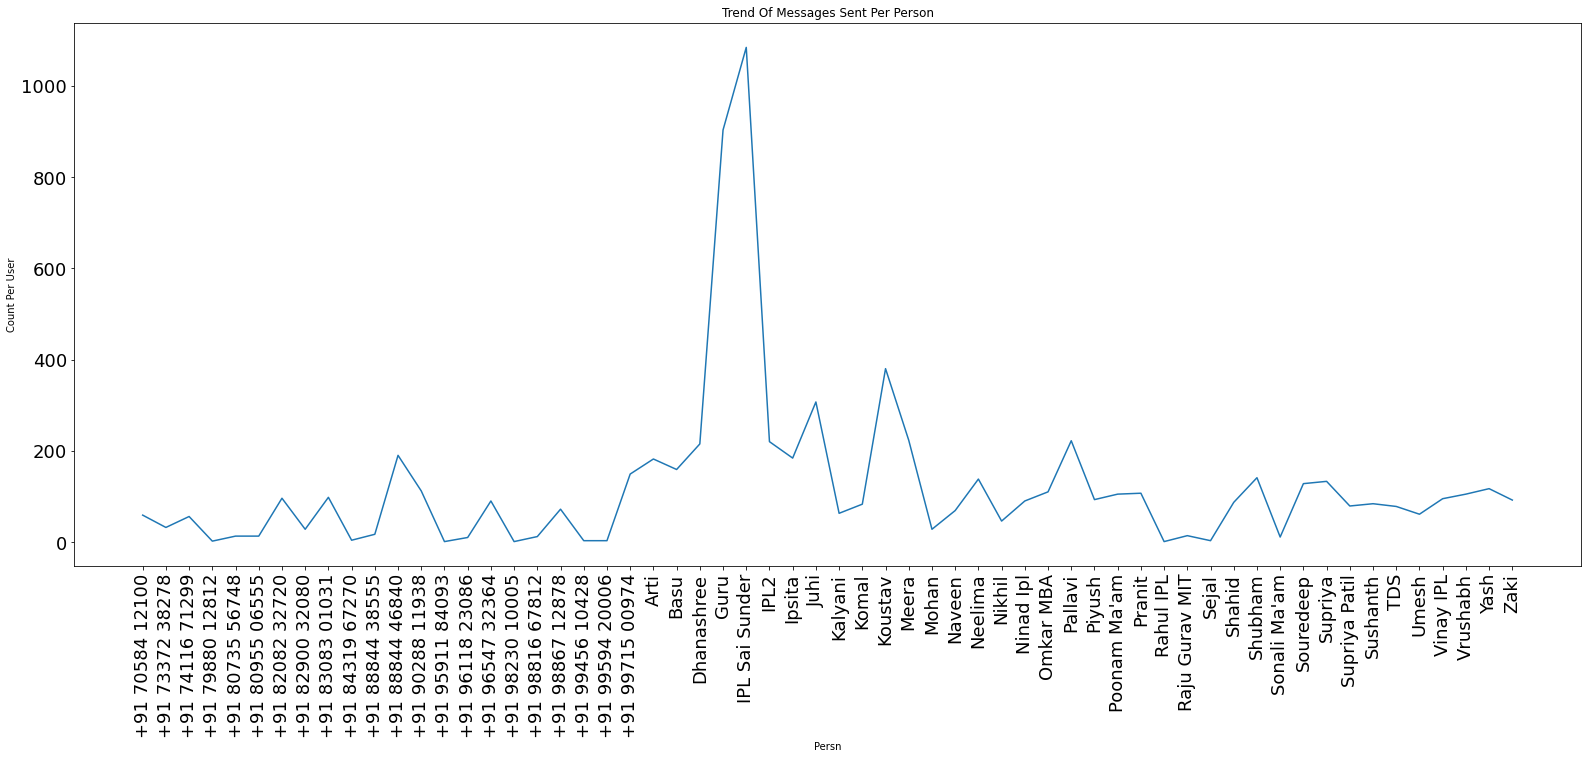

In [47]:
plt.figure(figsize = (27, 10)) 
plt.plot(new_df1.user, new_df1.CountPerUser)
plt.title('Trend Of Messages Sent Per Person')
plt.xlabel('Persn')
plt.xticks(rotation=90)
plt.tick_params(labelsize=18)
plt.ylabel('Count Per User')

Top 10 message counts with date

In [48]:
top10days = new_df.sort_values(by="message_count", ascending=False).head(10)    # Sort values according to the number of messages per day.
top10days.reset_index(inplace=True)           # reset index in order.
top10days.drop(columns="index", inplace=True) # dropping original indices.
top10days

,date,message_count
0,2019-09-03,156
1,2019-11-14,103
2,2019-11-15,76
3,2020-05-16,73
4,2020-01-14,72
5,2021-03-10,64
6,2020-03-11,61
7,2020-04-29,59
8,2021-02-12,56
9,2021-03-09,56


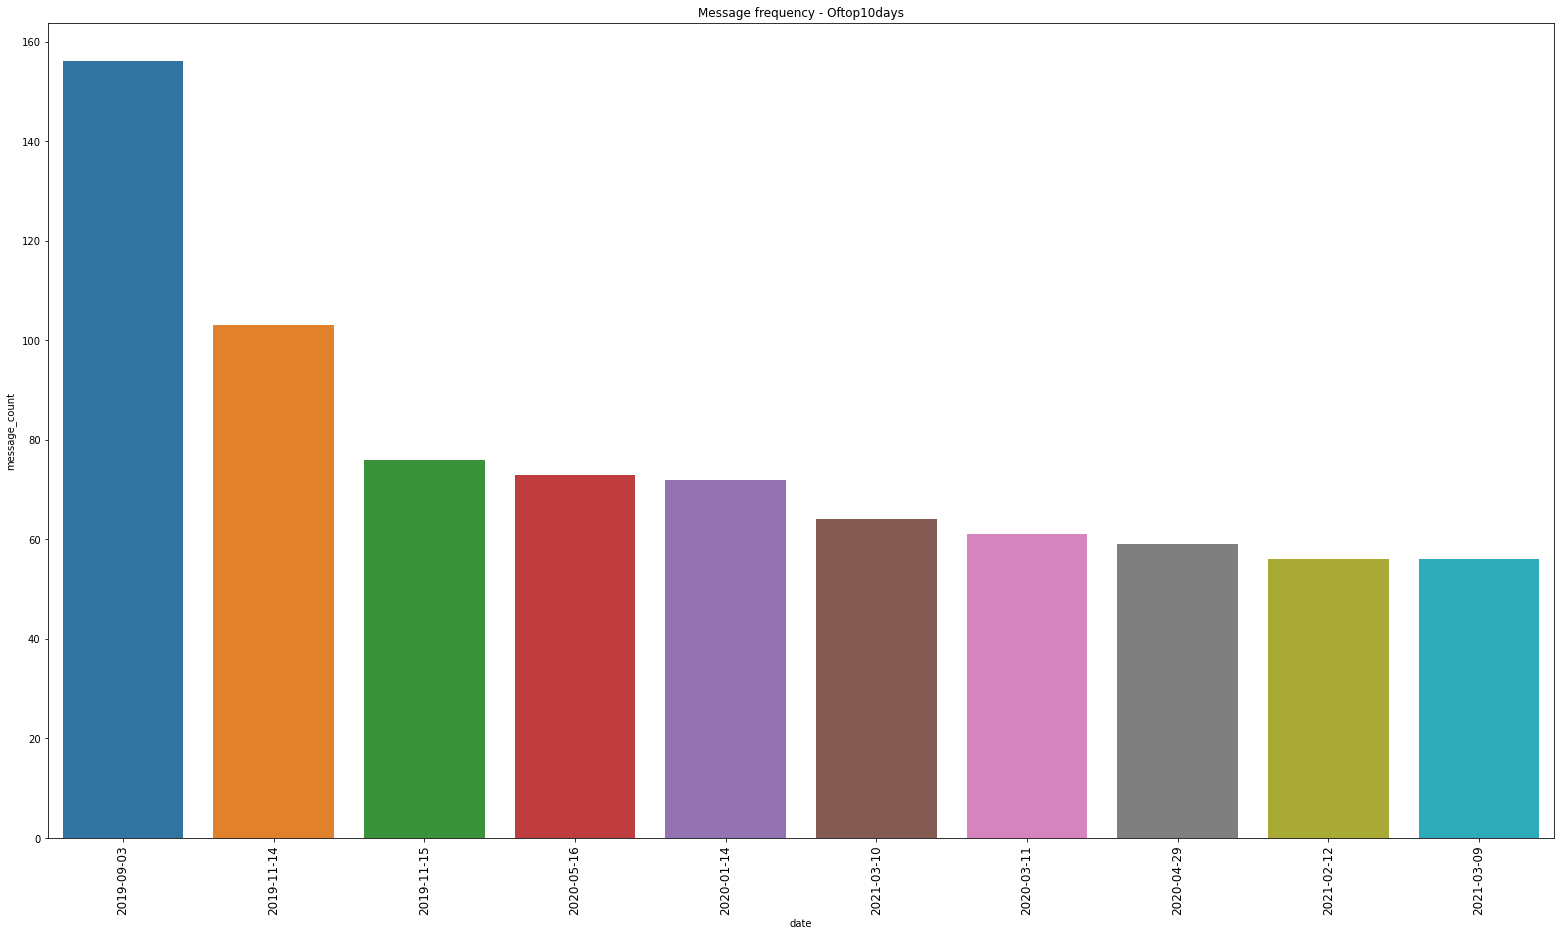

In [49]:
plt.figure(figsize = (27, 15)) 
plt.title('Message frequency - Oftop10days')
sns.barplot(top10days.date,top10days.message_count)
xlabel='date'
plt.tick_params(axis="x",labelsize=12, rotation=90)
ylabel='message_count'

Top 10 message count per user

In [50]:
df2 = df.copy()    
df2 = df2[df2.user != "group_notification"]
top10df = df2.groupby("user")["message"].count().sort_values(ascending=False)

# Final Data Frame
top10df = top10df.head(10).reset_index()
top10df

,user,message
0,IPL Sai Sunder,1084
1,Guru,903
2,Koustav,380
3,Juhi,307
4,Meera,223
5,Pallavi,222
6,IPL2,220
7,Dhanashree,215
8,+91 88844 46840,190
9,Ipsita,184


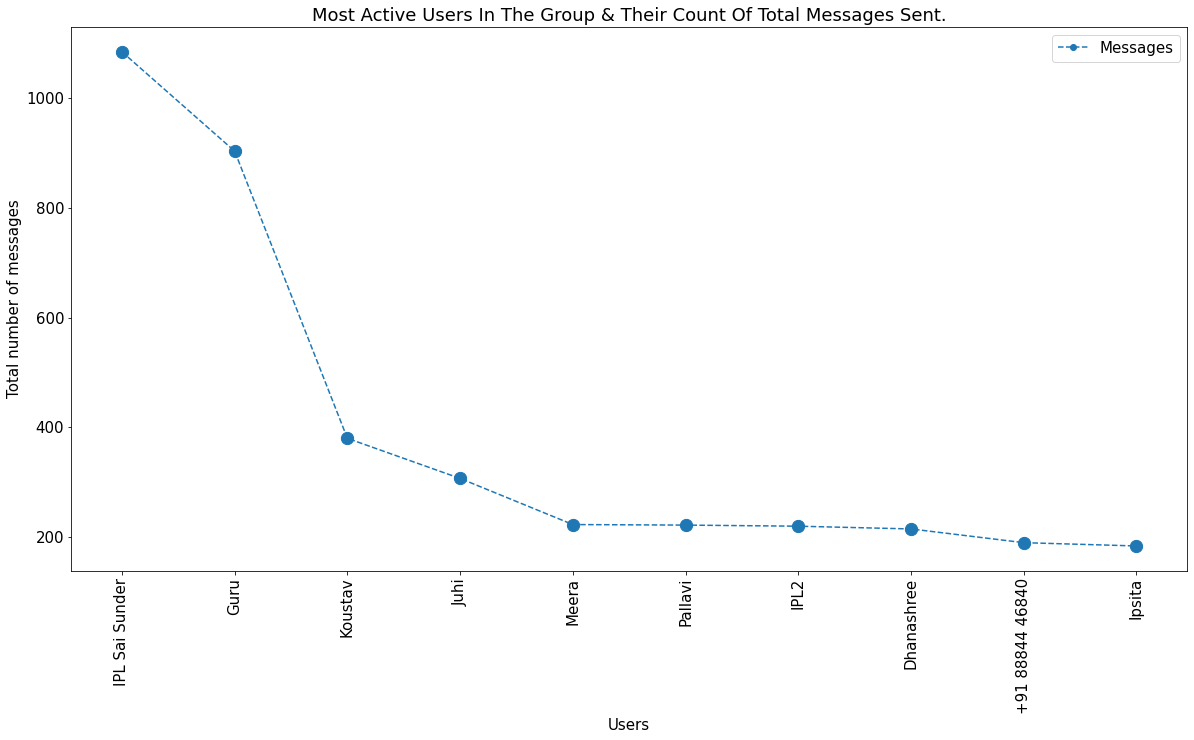

In [55]:
plt.rcParams['font.size'] = 15
plt.figure(figsize=(20,10))
#plt.bar(top10df.user, top10df.message)
plt.scatter(top10df.user, top10df.message,s=150)
plt.plot(top10df.user, top10df.message, marker='o', ls='--')

# Labels and Title 
plt.xlabel('Users')
plt.xticks(rotation=90)
plt.ylabel('Total number of messages')

plt.title("Most Active Users In The Group & Their Count Of Total Messages Sent.")
plt.legend(['Messages']);

Bottom 10 message count per user

In [52]:
df2 = df.copy()    
df2 = df2[df2.user != "group_notification"]
last10df = df2.groupby("user")["message"].count().sort_values(ascending=True)

# Final Data Frame
last10df = last10df.head(10).reset_index()
last10df

,user,message
0,+91 95911 84093,1
1,Rahul IPL,1
2,+91 98230 10005,1
3,+91 79880 12812,2
4,+91 99456 10428,3
5,+91 99594 20006,3
6,Sejal,3
7,+91 84319 67270,4
8,+91 96118 23086,10
9,Sonali Ma'am,11


Text(0.5, 1.0, 'Most Inative Users In The Group & Their Count Of Total Messages Sent.')

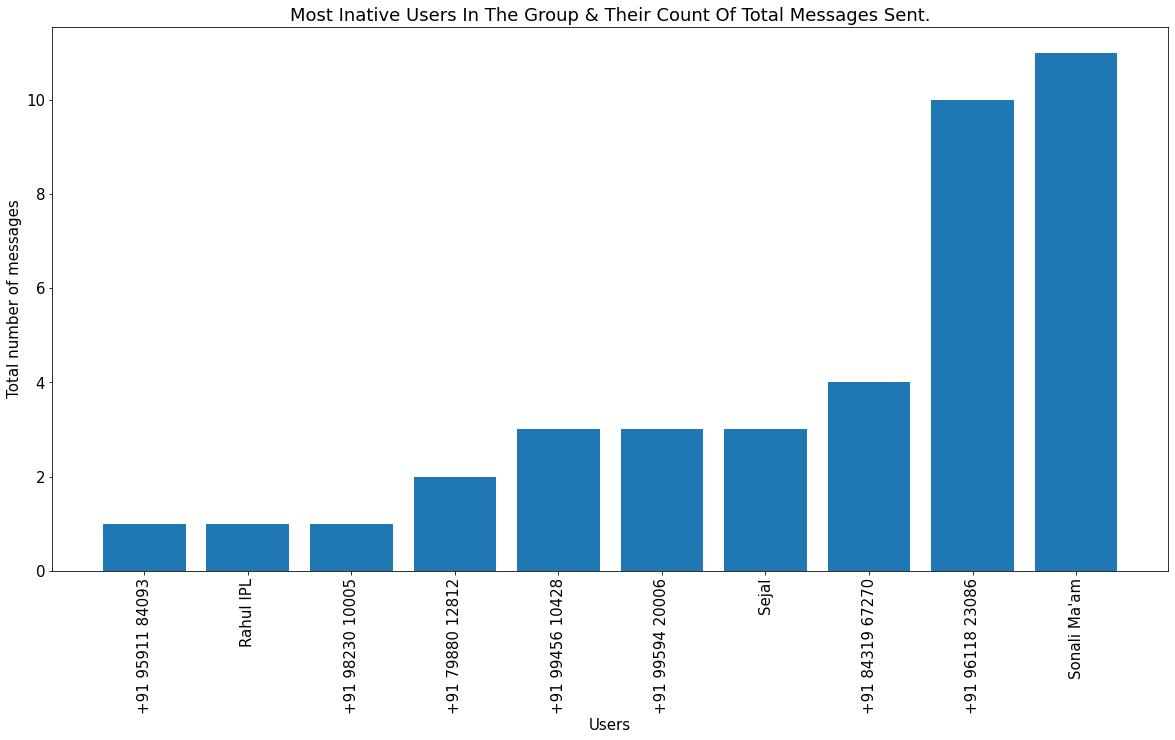

In [53]:
plt.figure(figsize=(20,10))
plt.bar(last10df.user, last10df.message)

plt.xlabel('Users')
plt.xticks(rotation=90)
plt.ylabel('Total number of messages')

plt.title("Most Inative Users In The Group & Their Count Of Total Messages Sent.")

Media sent by users

In [56]:
df[df.message == '<Media omitted> ']

,date_time,user,message,day,month,year,date
9,2019-08-12 16:23:00,Vinay IPL,<Media omitted>,Monday,Aug,2019,2019-08-12
16,2019-08-12 19:16:00,Vinay IPL,<Media omitted>,Monday,Aug,2019,2019-08-12
54,2019-08-18 20:06:00,Shubham,<Media omitted>,Sunday,Aug,2019,2019-08-18
80,2019-08-26 15:25:00,Juhi,<Media omitted>,Monday,Aug,2019,2019-08-26
91,2019-08-27 17:34:00,Vinay IPL,<Media omitted>,Tuesday,Aug,2019,2019-08-27
...,...,...,...,...,...,...,...
6808,2021-03-28 15:41:00,Souredeep,<Media omitted>,Sunday,Mar,2021,2021-03-28
6830,2021-03-31 09:30:00,IPL Sai Sunder,<Media omitted>,Wednesday,Mar,2021,2021-03-31
7178,2021-04-28 14:02:00,Koustav,<Media omitted>,Wednesday,Apr,2021,2021-04-28
7254,2021-05-17 18:50:00,IPL2,<Media omitted>,Monday,May,2021,2021-05-17


In [109]:
#top10media = df[df.message == '<Media omitted> '].groupby('user')["message"].count().sort_values(ascending = False)
top10media = df[df.message == '<Media omitted> '].groupby('user').count().sort_values(by="message", ascending = False).head(10)

# Dropping unused column;
top10media.drop(columns=['date_time', 'day', 'month', 'year', 'date'], inplace=True)

# Renaming column name for visualization;
top10media.rename(columns={"message": "media_sent"}, inplace=True)

# resetting index;
top10media.reset_index(inplace=True)

top10media

,user,media_sent
0,Guru,130
1,Juhi,47
2,IPL Sai Sunder,34
3,Poonam Ma'am,20
4,Pranit,15
5,Ninad Ipl,15
6,Yash,13
7,Omkar MBA,13
8,Souredeep,12
9,+91 83083 01031,11


Text(0.5, 1.0, 'Top 10 Total Media Sent by User.')

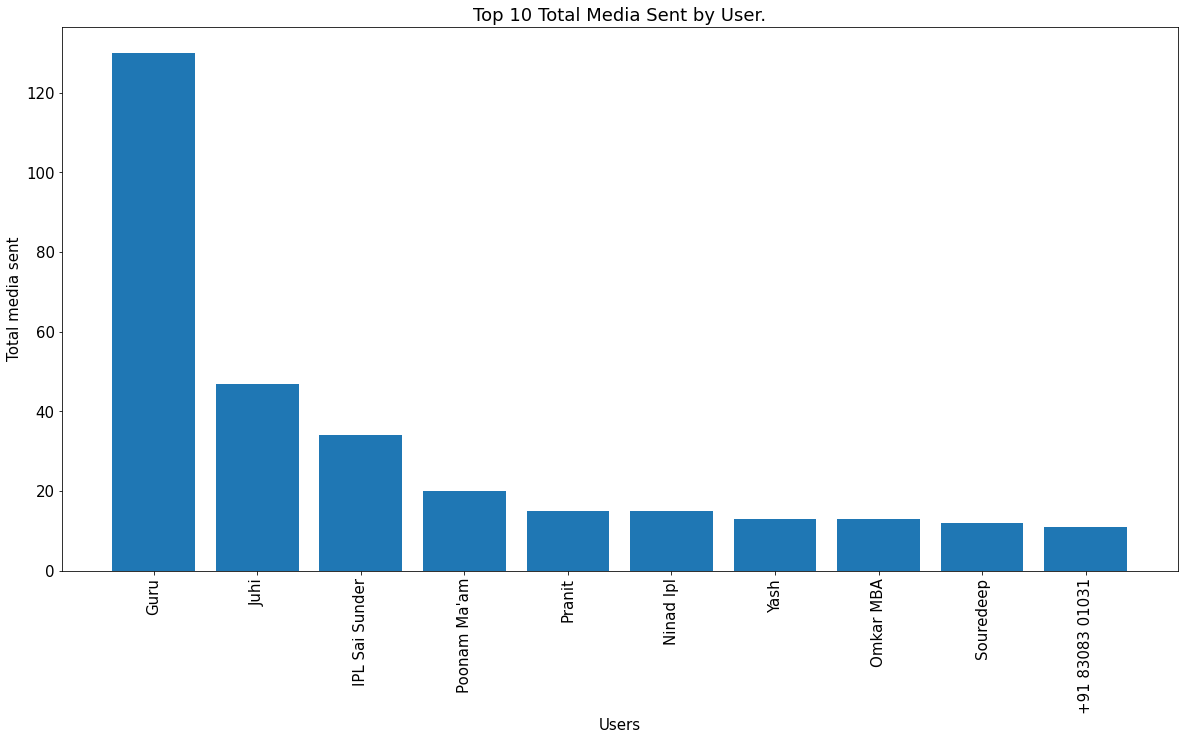

In [110]:
plt.figure(figsize=(20,10))
plt.bar(top10media.user, top10media.media_sent)

plt.xlabel('Users')
plt.xticks(rotation=90)
plt.ylabel('Total media sent')

plt.title("Top 10 Total Media Sent by User.")

Most active HOUR

In [154]:
df3 = df.copy()
df3['message_count'] = [1] * df.shape[0]    # new column that will keep count.
 
df3['hour'] = df3['date_time'].apply(lambda x: x.hour)
 
#grouped_by_time = df3.groupby('hour').sum().reset_index().sort_values(by = 'hour')
#df3 = df3.groupby('hour').sum().sort_values(by = 'hour').reset_index()
#df3.head(10)

grouped_by_time = df3.groupby('hour').sum().reset_index().sort_values(by = 'hour')

Text(0.5, 1.0, 'Total Messages Sent by each HOUR.')

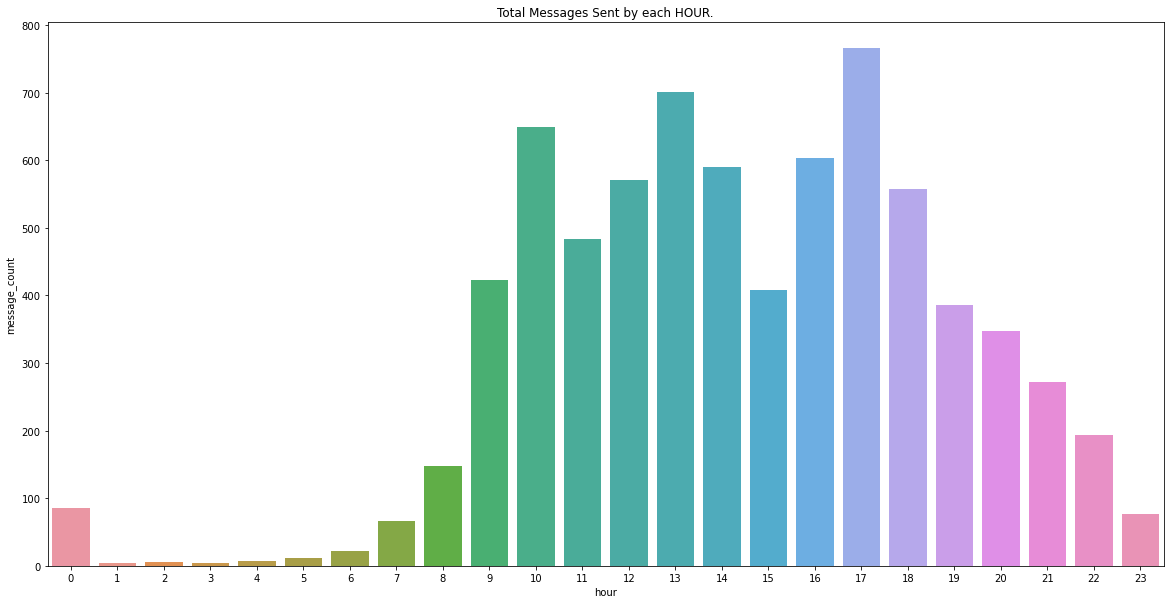

In [161]:
plt.figure(figsize=(20,10))
sns.barplot(grouped_by_time.hour, grouped_by_time.message_count)

plt.xlabel('hour')

plt.ylabel('message_count')

plt.title("Total Messages Sent by each HOUR.")

Most active DAYS

In [158]:
grouped_by_day = df3.groupby('day').sum().reset_index()[['day', 'message_count']]
grouped_by_day

,day,message_count
0,Friday,1231
1,Monday,991
2,Saturday,935
3,Sunday,407
4,Thursday,1264
5,Tuesday,1354
6,Wednesday,1202


Text(0.5, 1.0, 'Total Messages Sent each day.')

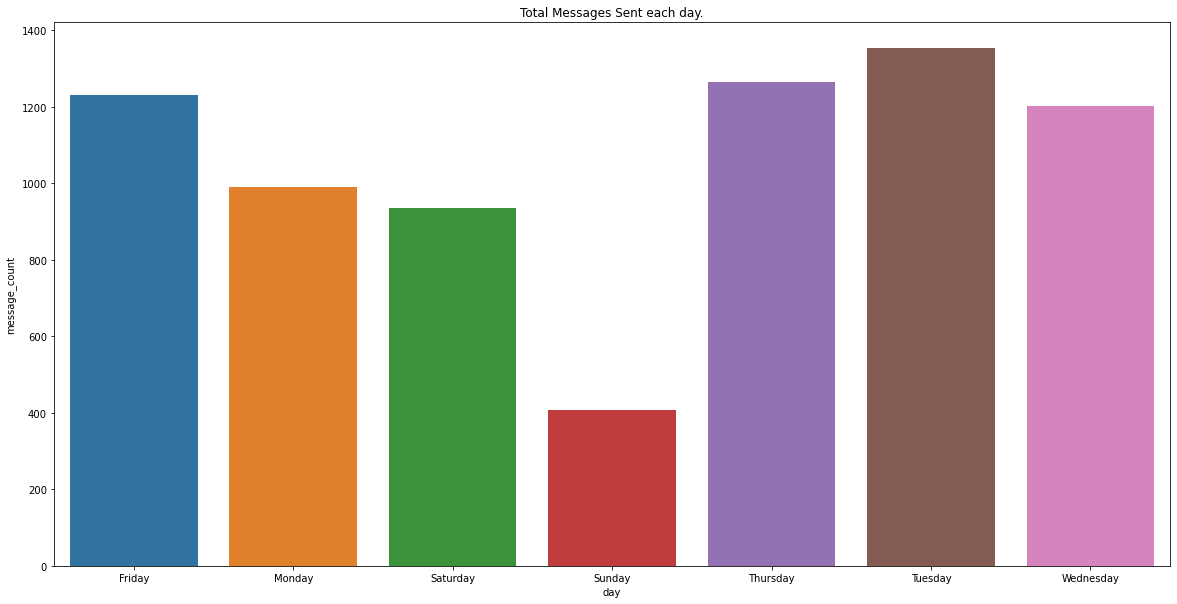

In [160]:
plt.figure(figsize=(20,10))
sns.barplot(grouped_by_day.day, grouped_by_day.message_count)

plt.xlabel('day')

plt.ylabel('message_count')

plt.title("Total Messages Sent each day.")

Messages sent per MONTH

In [180]:
grouped_by_month = df3.groupby('month').sum().reset_index()[['month','message_count']].sort_values(by="month")
#df3
#grouped_by_month

Text(0.5, 1.0, 'Total Messages Sent each month.')

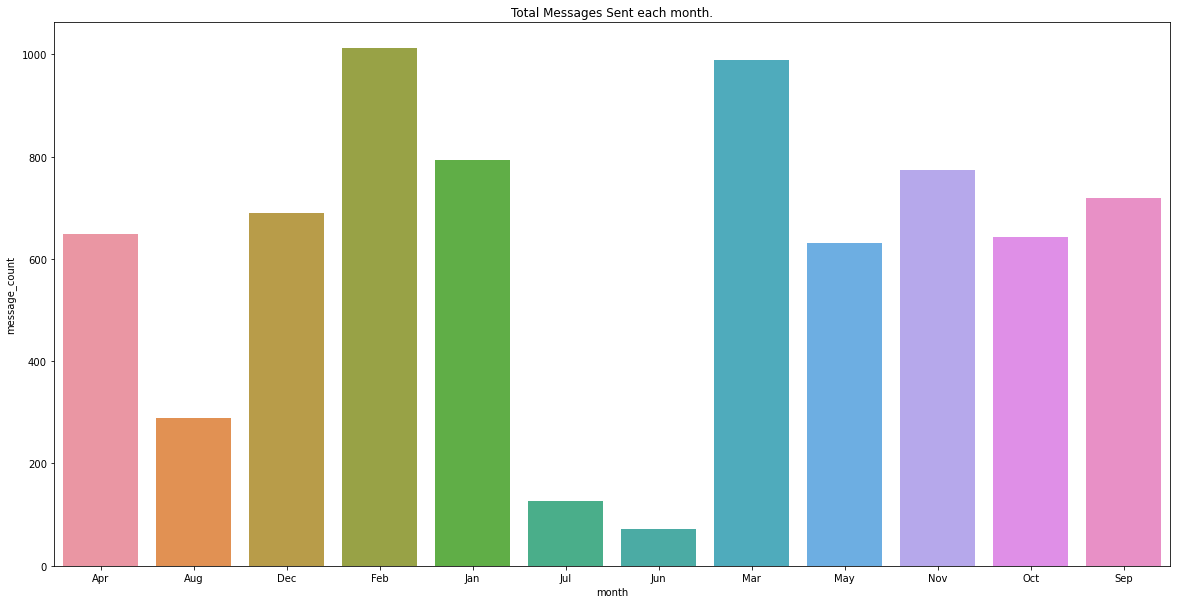

In [181]:
plt.figure(figsize=(20,10))
sns.barplot(grouped_by_month.month, grouped_by_month.message_count)

plt.xlabel('month')

plt.ylabel('message_count')

plt.title("Total Messages Sent each month.")